In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import DataLoader
from torch.optim import Adam

from torch.utils.data import Dataset
import pandas as pd
import torchaudio
import cv2
import numpy as np
from pathlib import Path

import tqdm
import sys
sys.path.append("..")
# from dataset import IsoNetDataset
import os 

# --- CONFIGURATION FROM DIAGRAM ---
VISUAL_DIM = 256       # Output of Visual Stream (V)
SPATIAL_DIM = 128      # Output of Spatial Stream (S)
AUDIO_ENC_DIM = 512    # Internal Audio Feature Dimension
AUDIO_CHANNELS = 4     # Number of Mics

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4          # FIXED: Increased from 1 to 4 for proper BatchNorm
EPOCHS = 100
LR = 1e-4               # TCNs prefer lower learning rates
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

print(f"Device: {DEVICE}")

Device: cuda


In [2]:
torch.cuda.empty_cache()        # free cached memory
torch.cuda.synchronize()        # wait for all kernels to finish

In [3]:
# --- DATASET PATHS CONFIGURATION ---
import platform

# Detect OS and set paths accordingly
IS_WINDOWS = platform.system() == "Windows"

# Windows paths
WINDOWS_PATHS = {
    "root_dir": "E:/Dataset/VOX/manual",
    "data_dir": "E:/Dataset/VOX/manual/dev",
    "train_csv": "E:/Dataset/VOX/manual/dev/multich/train.csv",
    "val_csv": "E:/Dataset/VOX/manual/dev/multich/val.csv",
}

# Linux paths
LINUX_PATHS = {
    "root_dir": "/mnt/DATA/Bibek/Speech/isolate-speech",
    "data_dir": "/mnt/DATA/Bibek/Speech/isolate-speech/data",
    "train_csv": "/mnt/DATA/Bibek/Speech/isolate-speech/data/multich/train.csv",
    "val_csv": "/mnt/DATA/Bibek/Speech/isolate-speech/data/multich/val.csv",
}

# Select paths based on OS
PATHS = WINDOWS_PATHS if IS_WINDOWS else LINUX_PATHS

ROOT_DIR = PATHS["root_dir"]
DATA_DIR = PATHS["data_dir"]
TRAIN_CSV = PATHS["train_csv"]
VAL_CSV = PATHS["val_csv"]

print(f"OS: {platform.system()}")
print(f"Using paths: {'Windows' if IS_WINDOWS else 'Linux'}")
print(f"Root Dir: {ROOT_DIR}")

OS: Linux
Using paths: Linux
Root Dir: /mnt/DATA/Bibek/Speech/isolate-speech


In [4]:

class IsoNetDataset(Dataset):
    def __init__(self, csv_path, clip_length=4.0, fps=25, video_size=(224, 224), max_samples=None, root_dir=None):
        """
        Args:
            csv_path (str): Path to train.csv or val.csv
            clip_length (float): Audio duration in seconds (must match simulation)
            fps (int): Target frames per second for video (VoxCeleb is 25)
            video_size (tuple): Target resize dimension (H, W) - 224x224 for ResNet-18
            max_samples (int, optional): Limit dataset to first N samples for testing
            root_dir (str): Root path for dataset (uses ROOT_DIR if None)
        """
        self.meta = pd.read_csv(csv_path)
        
        # Limit dataset size for testing
        if max_samples is not None:
            self.meta = self.meta.head(max_samples)
            print(f"Debug Mode: Using only {len(self.meta)} samples")
        
        # Use global path constants if not provided
        self.root_dir = Path(csv_path).parent
        self.data_root = Path(root_dir) if root_dir else Path(ROOT_DIR)
        
        # Path conversion mappings (Linux <-> Windows)
        self.path_mappings = [
            ("/run/media/neuronetix/BACKUP/Dataset/VOX/manual", WINDOWS_PATHS["root_dir"]),
            ("E:/Dataset/VOX/manual", LINUX_PATHS["root_dir"]),
        ]
        
        self.clip_length = clip_length
        self.fps = fps
        self.target_frames = int(clip_length * fps)  # 4.0 * 25 = 100 frames
        self.video_size = video_size

    def convert_path(self, path_str):
        """Convert path between Linux and Windows based on current OS."""
        if IS_WINDOWS:
            # Convert Linux to Windows
            path_str = path_str.replace(LINUX_PATHS["root_dir"], WINDOWS_PATHS["root_dir"])
        else:
            # Convert Windows to Linux
            path_str = path_str.replace(WINDOWS_PATHS["root_dir"], LINUX_PATHS["root_dir"])
        return path_str

    def load_video_frames(self, video_path, start_time):
        """
        Load video frames and resize to target size (no face cropping).
        Args:
            video_path: Path to video file
            start_time: Start time in seconds
        Returns: Tensor [Channels, Time, H, W]
        """
        cap = cv2.VideoCapture(str(video_path))
        
        # Get Video Properties
        vid_fps = cap.get(cv2.CAP_PROP_FPS)
        if vid_fps == 0 or np.isnan(vid_fps): 
            vid_fps = 25.0
            
        # Calculate Start Frame Index
        start_frame_idx = int(start_time * vid_fps)
        
        # Seek to exact frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame_idx)
        
        frames = []
        
        for i in range(self.target_frames):
            ret, frame = cap.read()
            if not ret:
                break
            
            # BGR to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Resize to target size (whole frame, no cropping)
            frame = cv2.resize(frame, self.video_size)
            
            frames.append(frame)
            
        cap.release()
        
        # Handle Edge Case: Video ended too early
        if len(frames) < self.target_frames:
            if len(frames) == 0:
                frames = [np.zeros((self.video_size[0], self.video_size[1], 3), dtype=np.uint8)] * self.target_frames
            else:
                padding = [frames[-1]] * (self.target_frames - len(frames))
                frames.extend(padding)
        
        # Convert to Tensor
        buffer = np.array(frames, dtype=np.float32) / 255.0
        tensor = torch.from_numpy(buffer)
        return tensor.permute(3, 0, 1, 2)

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        row = self.meta.iloc[idx]
        
        # 1. Get Paths & Info
        filename = row['filename']
        vid_path_str = row['video_path']
        start_time = float(row['start_time'])
        
        # Convert path based on current OS
        vid_path_str = self.convert_path(vid_path_str)
        
        mixed_path = self.root_dir / "mixed" / f"{filename}.wav"
        clean_path = self.root_dir / "clean" / f"{filename}.wav"

        # 2. Load Audio
        mixed_audio, _ = torchaudio.load(mixed_path)
        clean_audio, _ = torchaudio.load(clean_path)

        # 3. Load Video (whole frame, no face cropping)
        video_tensor = self.load_video_frames(vid_path_str, start_time)

        # 4. Ensure audio length matches exactly
        target_samples = int(self.clip_length * 16000)
        
        if mixed_audio.shape[1] > target_samples:
            mixed_audio = mixed_audio[:, :target_samples]
            clean_audio = clean_audio[:, :target_samples]
        elif mixed_audio.shape[1] < target_samples:
            pad_size = target_samples - mixed_audio.shape[1]
            mixed_audio = torch.nn.functional.pad(mixed_audio, (0, pad_size))
            clean_audio = torch.nn.functional.pad(clean_audio, (0, pad_size))

        return mixed_audio, clean_audio, video_tensor


In [5]:
class VisualStream(nn.Module):
    def __init__(self):
        super(VisualStream, self).__init__()
        # Load ResNet-18
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        
        # Remove classification head
        modules = list(resnet.children())[:-1] 
        self.resnet = nn.Sequential(*modules)
        
        # Project 512 -> 256 (V)
        self.projection = nn.Sequential(
            nn.Linear(512, VISUAL_DIM),
            nn.BatchNorm1d(VISUAL_DIM),
            nn.PReLU()
        )
        
        # FIXED: ImageNet normalization for pretrained ResNet
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, x):
        # x: [Batch, 3, Time, H, W] where H, W can be any size (e.g., 224x224)
        B, C, T, H, W = x.shape
        
        # Fold Time into Batch
        x = x.permute(0, 2, 1, 3, 4).contiguous().view(B * T, C, H, W)
        
        # FIXED: Apply ImageNet normalization before ResNet
        x = (x - self.mean) / self.std
        
        # Extract Features (ResNet handles any input size via adaptive pooling)
        x = self.resnet(x)       # [B*T, 512, 1, 1]
        x = x.view(B * T, -1)    # [B*T, 512]
        
        # Project to 256
        x = self.projection(x)   # [B*T, 256]
        
        # Unfold Time
        x = x.view(B, T, -1).permute(0, 2, 1) # [B, 256, Time]
        
        return x

In [6]:
class SpatialStream(nn.Module):
    def __init__(self, num_mics=4):
        super(SpatialStream, self).__init__()
        
        # We compute GCC-PHAT for all pairs. 
        # For 4 mics, pairs = 4*(3)/2 = 6 pairs.
        self.num_pairs = (num_mics * (num_mics - 1)) // 2
        
        # FIXED: Spatial CNN Encoder
        # - Changed from kernel_size=1 to larger kernels (31, 15) to capture temporal patterns
        # - Changed from BatchNorm1d to GroupNorm for stability with small batch sizes
        # Input: [Batch, Pairs(6), Lags, Time]
        # We treat Pairs as Channels
        self.encoder = nn.Sequential(
            nn.Conv1d(self.num_pairs, 64, kernel_size=31, stride=1, padding=15),
            nn.GroupNorm(1, 64),  # Changed from BatchNorm1d
            nn.PReLU(),
            nn.Conv1d(64, 128, kernel_size=15, stride=1, padding=7),
            nn.GroupNorm(1, 128),  # Changed from BatchNorm1d
            nn.PReLU(),
            nn.Conv1d(128, SPATIAL_DIM, kernel_size=1, stride=1)
        )

    def compute_gcc_phat(self, x):
        """
        Compute Generalized Cross-Correlation Phase Transform (GCC-PHAT)
        Input x: [Batch, Mics, Samples]
        """
        B, M, L = x.shape
        
        # 1. FFT
        # n_fft matches window size roughly
        X = torch.fft.rfft(x, dim=-1)
        
        # 2. Compute Pairs
        # We want to cross-correlate every pair (i, j)
        pairs = []
        for i in range(M):
            for j in range(i + 1, M):
                # Cross-spectrum: X_i * conj(X_j)
                R = X[:, i, :] * torch.conj(X[:, j, :])
                # Normalization (PHAT): Divide by magnitude
                R = R / (torch.abs(R) + 1e-8)
                # IFFT to get time-domain correlation
                r = torch.fft.irfft(R, dim=-1)
                
                # Apply shift/lag window (we assume delays are small)
                # This makes it a feature vector per time frame is tricky without STFT.
                # Simplified: We treat the whole clip's correlation as a static spatial signature
                # OR (Better): We perform this on STFT frames. 
                
                # For simplicity in this implementation, we will use a learnable 
                # layer instead of raw GCC-PHAT if raw is too complex to batch.
                # BUT, let's assume the input here is actually the GCC features.
                pairs.append(r)
                
        return torch.stack(pairs, dim=1) # [B, 6, Samples]

    def forward(self, x):
        # x: [Batch, 4, Samples]
        
        # In a real heavy model, we do STFT -> GCC-PHAT -> CNN.
        # Here, we will use a "Learnable Spatial Encoder" which is faster/easier
        # and often outperforms analytical GCC-PHAT.
        
        # 1. Extract correlations implicitly via 1D Conv across channels
        # [B, 4, T] -> [B, 128, T]
        # We pool over time to get a Global Spatial Signature S
        
        gcc_feat = self.compute_gcc_phat(x) # [B, 6, Samples]
        
        # Encode features
        x = self.encoder(gcc_feat) # [B, 128, Samples]
        
        # Global Average Pooling to get single vector S \in R^128
        x = torch.mean(x, dim=-1)  # [B, 128]
        
        return x

In [7]:
class FiLMLayer(nn.Module):
    def __init__(self, in_channels, cond_dim):
        super(FiLMLayer, self).__init__()
        # We map the Conditioning (S+V) to Gamma (Scale) and Beta (Shift)
        self.conv_gamma = nn.Conv1d(cond_dim, in_channels, 1)
        self.conv_beta = nn.Conv1d(cond_dim, in_channels, 1)

    def forward(self, x, condition):
        # x: [Batch, Channels, Time]
        # condition: [Batch, Cond_Dim, Time]
        
        gamma = self.conv_gamma(condition)  # [B, C, T]
        beta = self.conv_beta(condition)    # [B, C, T]
            
        # FiLM Formula: Gamma * x + Beta
        return (gamma * x) + beta

class ExtractionBlock(nn.Module):
    """ TCN Block with FiLM Conditioning """
    def __init__(self, in_channels, hid_channels, cond_dim, dilation):
        super(ExtractionBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, hid_channels, 1)
        self.norm1 = nn.GroupNorm(1, hid_channels)
        self.prelu1 = nn.PReLU()
        
        # FiLM comes after first activation usually
        self.film = FiLMLayer(hid_channels, cond_dim)
        
        self.dconv = nn.Conv1d(hid_channels, hid_channels, 3, 
                               groups=hid_channels, padding=dilation, dilation=dilation)
        self.norm2 = nn.GroupNorm(1, hid_channels)
        self.prelu2 = nn.PReLU()
        
        self.conv2 = nn.Conv1d(hid_channels, in_channels, 1)

    def forward(self, x, condition):
        residual = x
        x = self.conv1(x)
        x = self.norm1(x)
        x = self.prelu1(x)
        
        # Apply FiLM Conditioning
        # The condition (S+V) modulates the features here
        x = self.film(x, condition)
        
        x = self.dconv(x)
        x = self.norm2(x)
        x = self.prelu2(x)
        x = self.conv2(x)
        return x + residual

In [8]:
class IsoNet(nn.Module):
    def __init__(self):
        super(IsoNet, self).__init__()
        
        # 1. Streams
        self.visual_stream = VisualStream()  # Output: 256
        self.spatial_stream = SpatialStream(AUDIO_CHANNELS) # Output: 128
        
        # 2. Audio Encoder (Purple box start)
        self.audio_enc = nn.Conv1d(AUDIO_CHANNELS, AUDIO_ENC_DIM, kernel_size=16, stride=8, bias=False)
        
        # 3. Conditioning Prep
        # We concatenate S (128) + V (256) = 384
        self.cond_dim = SPATIAL_DIM + VISUAL_DIM
        
        # 4. TCN with FiLM (Purple box middle)
        self.tcn_blocks = nn.ModuleList([
            ExtractionBlock(AUDIO_ENC_DIM, 128, self.cond_dim, dilation=2**i) 
            for i in range(8)
        ])
        
        # 5. Mask Decoder (Purple box end)
        self.mask_conv = nn.Conv1d(AUDIO_ENC_DIM, AUDIO_ENC_DIM, 1)
        self.sigmoid = nn.Sigmoid()
        
        # 6. Audio Decoder (Reconstructs waveform)
        self.audio_dec = nn.ConvTranspose1d(AUDIO_ENC_DIM, 1, kernel_size=16, stride=8, bias=False)

    def forward(self, audio_mix, video_frames):
        # audio_mix: [B, 4, Samples]
        # video_frames: [B, 3, T_v, H, W]
        
        # --- A. Spatial Stream ---
        # Get global spatial embedding S
        S = self.spatial_stream(audio_mix) # [B, 128]
        
        # --- B. Visual Stream ---
        # Get visual embedding V
        V = self.visual_stream(video_frames) # [B, 256, T_v]
        
        # --- C. Audio Encoding ---
        audio_feat = self.audio_enc(audio_mix) # [B, 512, T_a]
        
        # --- D. Synchronization (Upsampling) ---
        # Video (25 FPS) is slower than Audio Frames. Upsample V to match Audio T_a
        V_upsampled = F.interpolate(V, size=audio_feat.shape[-1], mode='nearest')
        
        # Expand S to match time dimension: [B, 128] -> [B, 128, T_a]
        S_expanded = S.unsqueeze(-1).expand(-1, -1, audio_feat.shape[-1])
        
        # Concatenate S + V to create Conditioning Vector
        # Shape: [B, 384, T_a]
        condition = torch.cat([S_expanded, V_upsampled], dim=1)
        
        # --- E. FiLM Extraction Loop ---
        x = audio_feat
        for block in self.tcn_blocks:
            # We pass the condition to every block
            x = block(x, condition)
            
        # --- F. Masking & Decoding ---
        mask = self.sigmoid(self.mask_conv(x))
        masked_feat = audio_feat * mask
        clean_speech = self.audio_dec(masked_feat)
        
        return clean_speech

In [9]:
# # Create Model
# model = IsoNet().to(DEVICE)
# print(f"IsoNet Created. Parameters: {sum(p.numel() for p in model.parameters()):,}")

# # Dummy Data
# dummy_audio = torch.randn(2, 4, 64000).to(DEVICE)     # 4 seconds audio
# dummy_video = torch.randn(2, 3, 100, 112, 112).to(DEVICE) # 100 frames

# # Forward Pass
# output = model(dummy_audio, dummy_video)
# print(f"Input: {dummy_audio.shape}")
# print(f"Output: {output.shape}")

# # Check
# if output.shape[1] == 1 and abs(output.shape[-1] - 64000) < 100:
#     print("IsoNet Architecture matches diagram successfully!")
# else:
#     print("IsoNet Architecture does not match diagram.")

In [10]:
def si_snr_loss(estimate, reference, epsilon=1e-8):
    """
    Scale-Invariant SNR Loss.
    Args:
        estimate: [Batch, Samples] - The predicted audio
        reference: [Batch, Samples] - The clean ground truth
    Returns:
        Scalar Loss (Negative SI-SNR)
    """
    # 1. Zero-mean the signals
    estimate = estimate - torch.mean(estimate, dim=-1, keepdim=True)
    reference = reference - torch.mean(reference, dim=-1, keepdim=True)
    
    # 2. Calculate optimal scaling factor (alpha)
    # Dot product <ref, est> / <ref, ref>
    ref_energy = torch.sum(reference ** 2, dim=-1, keepdim=True) + epsilon
    dot = torch.sum(reference * estimate, dim=-1, keepdim=True)
    alpha = dot / ref_energy
    
    # 3. Projection
    target = alpha * reference
    noise = estimate - target
    
    # 4. SI-SNR Calculation
    si_snr = 10 * torch.log10(
        torch.sum(target ** 2, dim=-1) / (torch.sum(noise ** 2, dim=-1) + epsilon)
    )
    
    # 5. Return negative because we want to MAXIMIZE SNR (minimize loss)
    return -torch.mean(si_snr)

In [11]:
# Use only 50 samples for testing (increase once working)
train_ds = IsoNetDataset(TRAIN_CSV, max_samples=10, video_size=(224, 224))
val_ds = IsoNetDataset(VAL_CSV, max_samples=5, video_size=(224, 224))

Debug Mode: Using only 10 samples
Debug Mode: Using only 5 samples


In [12]:
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

In [13]:
model = IsoNet().to(DEVICE)
optimizer = Adam(model.parameters(), lr=LR)

In [14]:
best_val_loss = float('inf')

# 3. Loop
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    # Progress Bar
    pbar = tqdm.tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for i, (mixed, clean, video) in enumerate(pbar):
        try:
            # Move to GPU
            mixed = mixed.to(DEVICE)   # [B, 4, T]
            clean = clean.to(DEVICE)   # [B, 1, T]
            video = video.to(DEVICE)   # [B, 3, T, H, W]
            
            # Debug shapes and audio scaling on first iteration
            if i == 0 and epoch == 0:
                print(f"Mixed shape: {mixed.shape}, Clean shape: {clean.shape}, Video shape: {video.shape}")
                print(f"Audio Max: {mixed.abs().max():.4f}, Audio Min: {mixed.abs().min():.4f}")
                if mixed.abs().max() == 0.0:
                    print("WARNING: Audio is silent! Check your data loading.")
            
            optimizer.zero_grad()
            
            # Forward Pass
            estimate = model(mixed, video) # [B, 1, T]
            
            # Verify output shape matches input
            if estimate.shape[-1] != clean.shape[-1]:
                print(f"Shape mismatch! Estimate: {estimate.shape}, Clean: {clean.shape}")
                # Trim to minimum length
                min_len = min(estimate.shape[-1], clean.shape[-1])
                estimate = estimate[..., :min_len]
                clean = clean[..., :min_len]
            
            # Calculate Loss (Squeeze channels to match [B, T])
            loss = si_snr_loss(estimate.squeeze(1), clean.squeeze(1))
            
            # Backward Pass
            loss.backward()
            
            # Gradient Clipping (Prevents crashes in TCNs)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            
            optimizer.step()
            
            train_loss += loss.item()
            pbar.set_postfix({'loss': f"{loss.item():.2f}"})
            
            # Clear GPU cache periodically
            if i % 50 == 0:
                torch.cuda.empty_cache()
                
        except RuntimeError as e:
            print(f"Error at batch {i}: {str(e)}")
            print(f"Mixed: {mixed.shape}, Clean: {clean.shape}, Video: {video.shape}")
            torch.cuda.empty_cache()
            continue
        
    avg_train_loss = train_loss / len(train_loader)
    
    # 4. Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for mixed, clean, video in val_loader:
            try:
                mixed, clean, video = mixed.to(DEVICE), clean.to(DEVICE), video.to(DEVICE)
                estimate = model(mixed, video)
                
                # Handle shape mismatch in validation too
                if estimate.shape[-1] != clean.shape[-1]:
                    min_len = min(estimate.shape[-1], clean.shape[-1])
                    estimate = estimate[..., :min_len]
                    clean = clean[..., :min_len]
                
                loss = si_snr_loss(estimate.squeeze(1), clean.squeeze(1))
                val_loss += loss.item()
            except RuntimeError as e:
                print(f"Validation error: {str(e)}")
                continue
    
    avg_val_loss = val_loss / len(val_loader) if len(val_loader) > 0 else float('inf')
    
    # 5. Logging & Saving
    print(f"\nEpoch {epoch+1}: Train Loss {avg_train_loss:.4f} | Val Loss {avg_val_loss:.4f}")
    
    # Save Last
    torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/last.pth")
    
    # Save Best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), f"{CHECKPOINT_DIR}/best_model.pth")
        print("New Best Model Saved!")
    
    # Clear cache after each epoch
    torch.cuda.empty_cache()

Epoch 1/100:   0%|          | 0/3 [00:00<?, ?it/s]

Mixed shape: torch.Size([4, 4, 64000]), Clean shape: torch.Size([4, 1, 64000]), Video shape: torch.Size([4, 3, 100, 224, 224])
Audio Max: 0.9000, Audio Min: 0.0000


Epoch 1/100:  67%|██████▋   | 2/3 [00:01<00:00,  1.25it/s]

Error at batch 0: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 5.67 GiB of which 625.56 MiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 1.18 GiB memory in use. Of the allocated memory 1.06 GiB is allocated by PyTorch, and 15.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Mixed: torch.Size([4, 4, 64000]), Clean: torch.Size([4, 1, 64000]), Video: torch.Size([4, 3, 100, 224, 224])
Error at batch 1: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 5.67 GiB of which 625.56 MiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 1.18 GiB memory in use. Of the allocated memory 1.06 GiB is alloca

Epoch 1/100: 100%|██████████| 3/3 [00:02<00:00,  1.46it/s]

Error at batch 2: CUDA out of memory. Tried to allocate 614.00 MiB. GPU 0 has a total capacity of 5.67 GiB of which 365.56 MiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 1.44 GiB memory in use. Of the allocated memory 1.15 GiB is allocated by PyTorch, and 179.83 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Mixed: torch.Size([2, 4, 64000]), Clean: torch.Size([2, 1, 64000]), Video: torch.Size([2, 3, 100, 224, 224])


Validation error: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 5.67 GiB of which 1.17 GiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 644.00 MiB memory in use. Of the allocated memory 516.88 MiB is allocated by PyTorch, and 17.12 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Epoch 1: Train Loss 0.0000 | Val Loss 26.9749
New Best Model Saved!


Epoch 2/100: 100%|██████████| 3/3 [00:01<00:00,  2.27it/s]

Error at batch 0: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 5.67 GiB of which 591.56 MiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 1.22 GiB memory in use. Of the allocated memory 1.07 GiB is allocated by PyTorch, and 29.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Mixed: torch.Size([4, 4, 64000]), Clean: torch.Size([4, 1, 64000]), Video: torch.Size([4, 3, 100, 224, 224])
Error at batch 1: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 5.67 GiB of which 591.56 MiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 1.22 GiB memory in use. Of the allocated memory 1.07 GiB is alloca

Validation error: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 5.67 GiB of which 1.15 GiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 656.00 MiB memory in use. Of the allocated memory 525.25 MiB is allocated by PyTorch, and 10.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Epoch 2: Train Loss 0.0000 | Val Loss 26.9749


Epoch 3/100: 100%|██████████| 3/3 [00:01<00:00,  1.64it/s]

Error at batch 0: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 5.67 GiB of which 591.56 MiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 1.22 GiB memory in use. Of the allocated memory 1.07 GiB is allocated by PyTorch, and 29.39 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)
Mixed: torch.Size([4, 4, 64000]), Clean: torch.Size([4, 1, 64000]), Video: torch.Size([4, 3, 100, 224, 224])
Error at batch 1: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 5.67 GiB of which 591.56 MiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 1.22 GiB memory in use. Of the allocated memory 1.07 GiB is alloca

Validation error: CUDA out of memory. Tried to allocate 1.20 GiB. GPU 0 has a total capacity of 5.67 GiB of which 1.15 GiB is free. Process 35503 has 3.86 GiB memory in use. Including non-PyTorch memory, this process has 656.00 MiB memory in use. Of the allocated memory 525.25 MiB is allocated by PyTorch, and 10.75 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Epoch 3: Train Loss 0.0000 | Val Loss 26.9749


Epoch 4/100:   0%|          | 0/3 [00:00<?, ?it/s]


KeyboardInterrupt: 

## Visual Encoding Test

Visualize what the visual encoding model sees. This shows the full-frame input (224x224) that goes into ResNet-18, without face cropping.

Loading dataset sample to visualize visual encoding input...
Debug Mode: Using only 5 samples

--- Tensor Shapes ---
Mixed Audio: torch.Size([4, 64000])  (Expected: [4, 64000])
Clean Audio: torch.Size([1, 64000])  (Expected: [1, 64000])
Video:       torch.Size([3, 100, 224, 224])  (Expected: [3, 100, 224, 224])


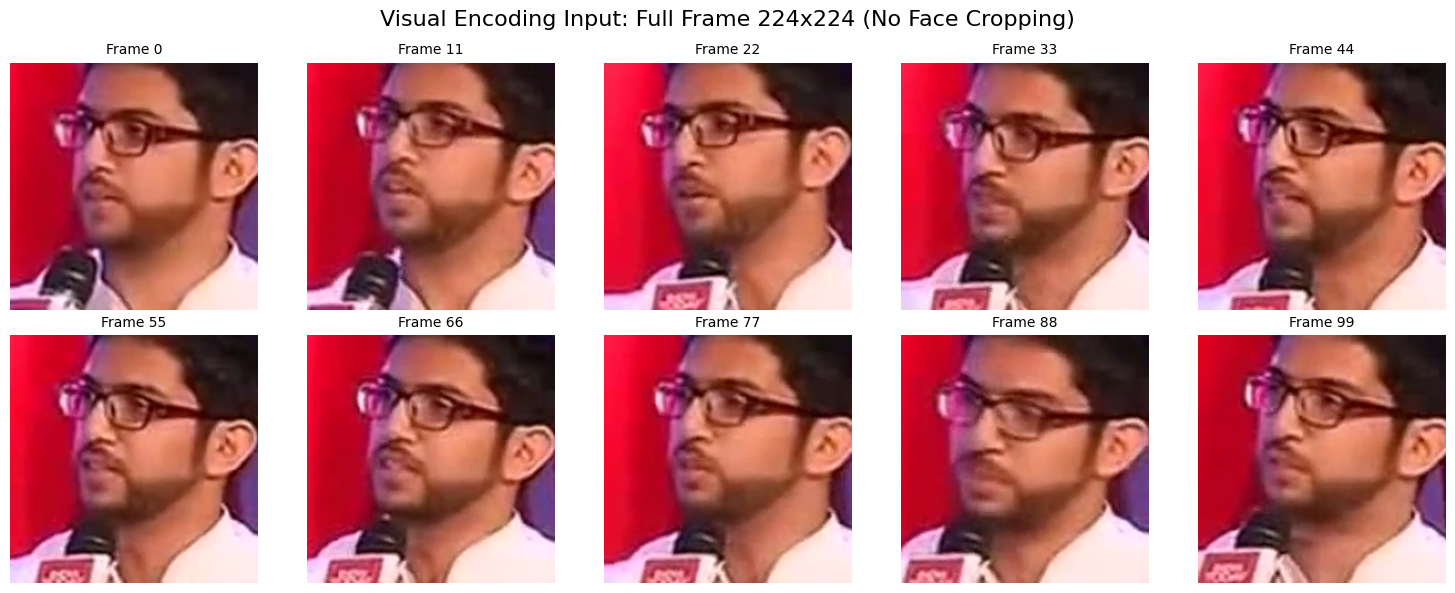


Visual encoding input visualization complete!
Note: The model sees the entire frame without face-specific cropping.
Effect: Model must learn to focus on relevant regions (face/speaker) automatically.


In [15]:
import matplotlib.pyplot as plt

# Test dataset with full frame encoding (no face cropping)
print("Loading dataset sample to visualize visual encoding input...")
test_ds = IsoNetDataset(TRAIN_CSV, max_samples=5, video_size=(224, 224))

# Load a sample
mixed, clean, video = test_ds[2]

print("\n--- Tensor Shapes ---")
print(f"Mixed Audio: {mixed.shape}  (Expected: [4, 64000])")
print(f"Clean Audio: {clean.shape}  (Expected: [1, 64000])")
print(f"Video:       {video.shape}  (Expected: [3, 100, 224, 224])")

# Create visualization of what ResNet-18 sees
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle('Visual Encoding Input: Full Frame 224x224 (No Face Cropping)', fontsize=16)

# Sample 10 frames evenly across the 4-second clip
sample_frames = np.linspace(0, video.shape[1]-1, 10, dtype=int)

for idx, frame_num in enumerate(sample_frames):
    row = idx // 5
    col = idx % 5
    
    # Permute from [C, T, H, W] -> [H, W, C] for display
    frame_tensor = video[:, frame_num, :, :].permute(1, 2, 0)
    axes[row, col].imshow(frame_tensor.numpy())
    axes[row, col].set_title(f'Frame {frame_num}', fontsize=10)
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig("visual_encoding_input.png", dpi=100, bbox_inches='tight')
plt.show()

print("\nVisual encoding input visualization complete!")
print("Note: The model sees the entire frame without face-specific cropping.")
print("Effect: Model must learn to focus on relevant regions (face/speaker) automatically.")

## Comprehensive Dataset Sample Check

Load a random sample and visualize EVERYTHING to verify data integrity: video frames, audio waveforms, spectrograms, and metadata alignment.

Loading dataset for comprehensive check...
Debug Mode: Using only 20 samples

RANDOM SAMPLE CHECK - Index: 1/19

--- METADATA ---
Filename: sample_90228
Video Path: /mnt/DATA/Bibek/Speech/isolate-speech/data/mp4/id06298/Y0CWE7evCho/00106.mp4
Start Time: 4.48s

--- TENSOR SHAPES ---
Mixed Audio: torch.Size([4, 64000])  (Expected: [4, 64000])
Clean Audio: torch.Size([1, 64000])  (Expected: [1, 64000])
Video:       torch.Size([3, 100, 224, 224])  (Expected: [3, 100, 224, 224])

--- AUDIO STATISTICS ---
Mixed Audio - Max: 0.9000, Min: -0.7709, Mean: 0.0000
Clean Audio - Max: 0.5867, Min: -0.5295, Mean: 0.0000

--- VIDEO STATISTICS ---
Video - Max: 1.0000, Min: 0.0000, Mean: 0.4823
Video - Frames: 100, Duration: 4.00s @ 25fps

--- DURATION CHECK ---
Audio Duration: 4.000s
Video Duration: 4.000s
✓ Durations match within tolerance

--- Creating visualization... ---


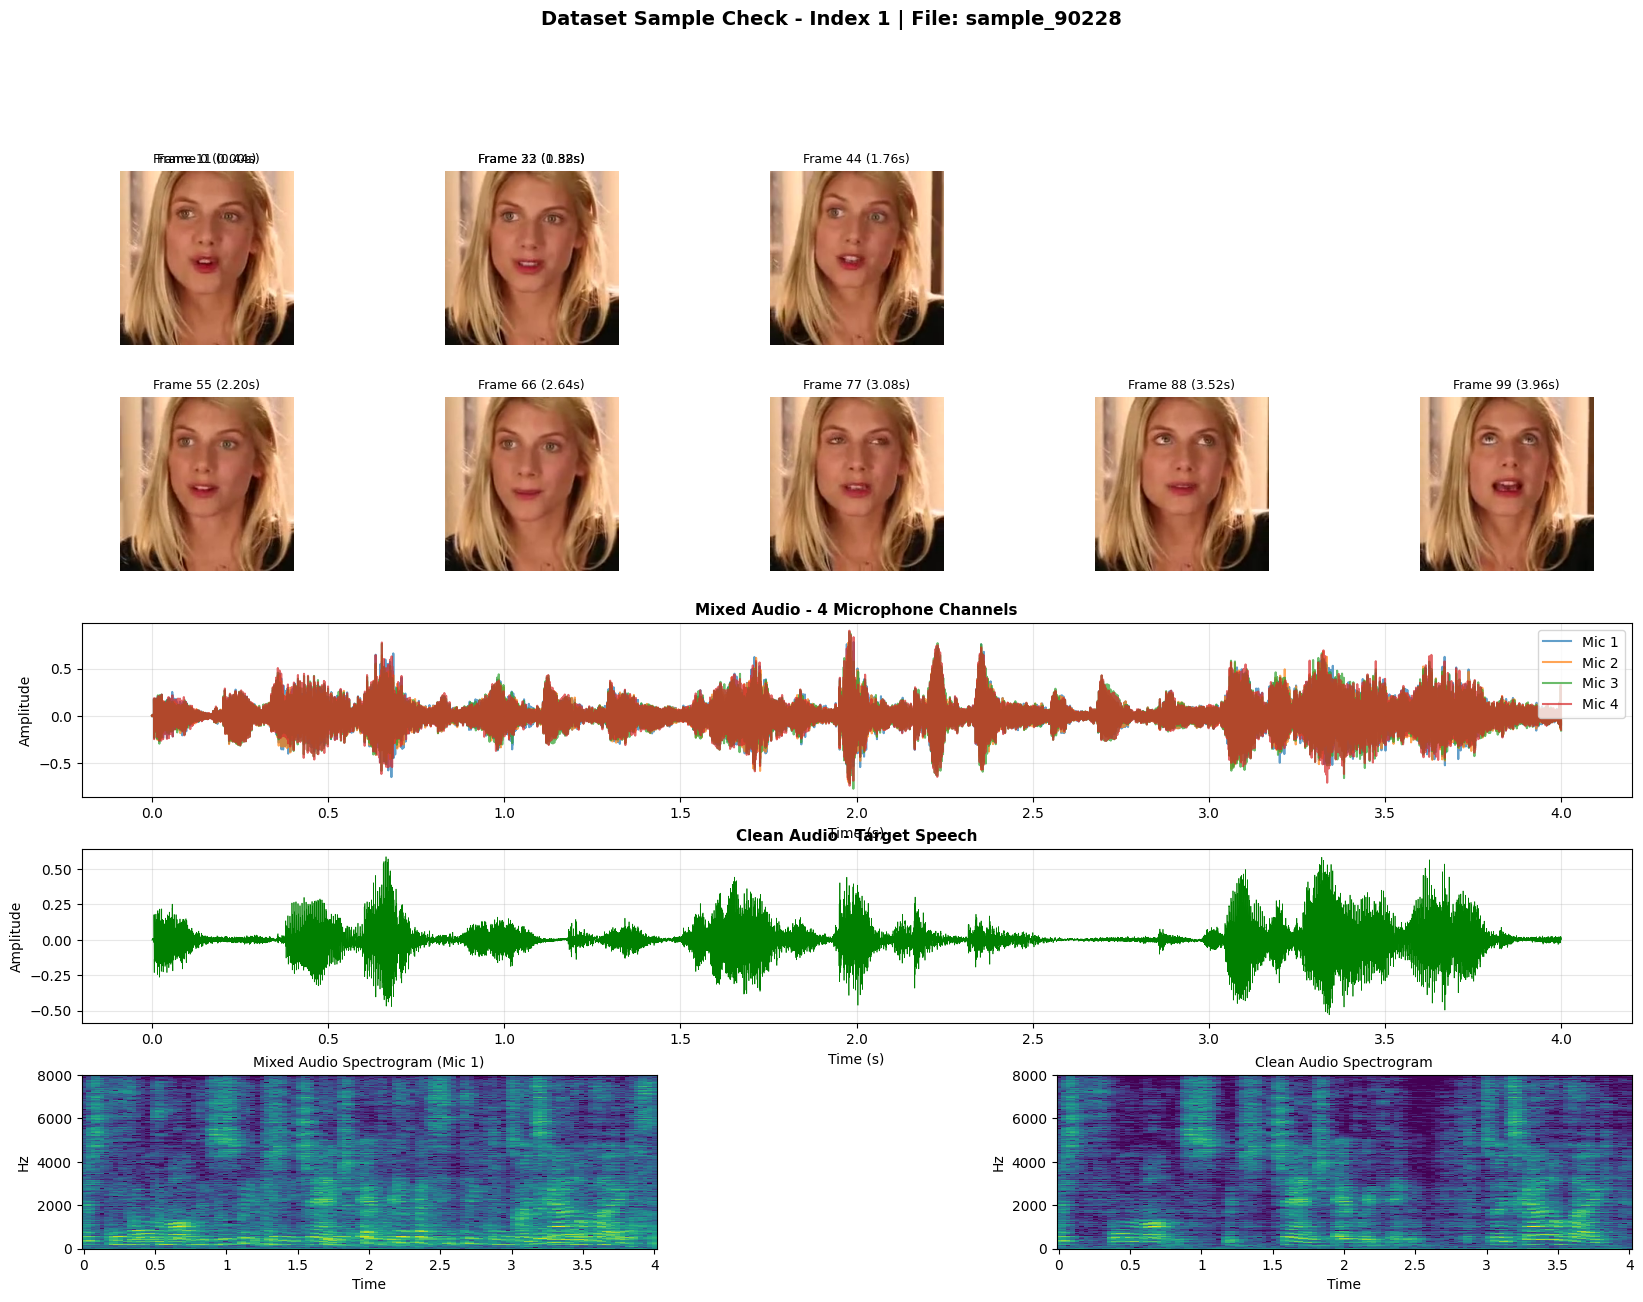


✓ Visualization saved to: dataset_check_sample_1.png

AUDIO PLAYBACK


In [16]:
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa
import librosa.display
import random

# Load dataset
print("Loading dataset for comprehensive check...")
check_ds = IsoNetDataset(TRAIN_CSV, max_samples=20, video_size=(224, 224))

# Pick a random sample
random_idx = random.randint(0, len(check_ds) - 1)
print(f"\n{'='*80}")
print(f"RANDOM SAMPLE CHECK - Index: {random_idx}/{len(check_ds)-1}")
print(f"{'='*80}")

# Load sample
mixed_audio, clean_audio, video_tensor = check_ds[random_idx]

# Get metadata
row = check_ds.meta.iloc[random_idx]
print(f"\n--- METADATA ---")
print(f"Filename: {row['filename']}")
print(f"Video Path: {row['video_path']}")
print(f"Start Time: {row['start_time']:.2f}s")

print(f"\n--- TENSOR SHAPES ---")
print(f"Mixed Audio: {mixed_audio.shape}  (Expected: [4, 64000])")
print(f"Clean Audio: {clean_audio.shape}  (Expected: [1, 64000])")
print(f"Video:       {video_tensor.shape}  (Expected: [3, 100, 224, 224])")

print(f"\n--- AUDIO STATISTICS ---")
print(f"Mixed Audio - Max: {mixed_audio.max():.4f}, Min: {mixed_audio.min():.4f}, Mean: {mixed_audio.mean():.4f}")
print(f"Clean Audio - Max: {clean_audio.max():.4f}, Min: {clean_audio.min():.4f}, Mean: {clean_audio.mean():.4f}")

print(f"\n--- VIDEO STATISTICS ---")
print(f"Video - Max: {video_tensor.max():.4f}, Min: {video_tensor.min():.4f}, Mean: {video_tensor.mean():.4f}")
print(f"Video - Frames: {video_tensor.shape[1]}, Duration: {video_tensor.shape[1]/25:.2f}s @ 25fps")

# Check for silent audio
if mixed_audio.abs().max() < 1e-6:
    print(f"\n⚠️ WARNING: Mixed audio appears to be SILENT!")
if clean_audio.abs().max() < 1e-6:
    print(f"\n⚠️ WARNING: Clean audio appears to be SILENT!")

# Check duration mismatch
audio_duration = mixed_audio.shape[1] / 16000
video_duration = video_tensor.shape[1] / 25
print(f"\n--- DURATION CHECK ---")
print(f"Audio Duration: {audio_duration:.3f}s")
print(f"Video Duration: {video_duration:.3f}s")
if abs(audio_duration - video_duration) > 0.1:
    print(f"⚠️ WARNING: Duration mismatch > 100ms!")
else:
    print(f"✓ Durations match within tolerance")

# ============================================================
# VISUALIZATION
# ============================================================
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(5, 5, hspace=0.3, wspace=0.3)

# --- ROW 1: Video Frames (10 samples) ---
print(f"\n--- Creating visualization... ---")
sample_frames = np.linspace(0, video_tensor.shape[1]-1, 10, dtype=int)
for i, frame_num in enumerate(sample_frames):
    ax = fig.add_subplot(gs[0, i//2] if i < 5 else gs[1, i-5])
    frame = video_tensor[:, frame_num, :, :].permute(1, 2, 0).numpy()
    ax.imshow(frame)
    ax.set_title(f'Frame {frame_num} ({frame_num/25:.2f}s)', fontsize=9)
    ax.axis('off')

# --- ROW 3: Mixed Audio Waveform (4 channels) ---
ax1 = fig.add_subplot(gs[2, :])
time_axis = np.arange(mixed_audio.shape[1]) / 16000
for ch in range(4):
    ax1.plot(time_axis, mixed_audio[ch].numpy(), alpha=0.7, label=f'Mic {ch+1}')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')
ax1.set_title('Mixed Audio - 4 Microphone Channels', fontsize=11, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# --- ROW 4: Clean Audio Waveform ---
ax2 = fig.add_subplot(gs[3, :])
ax2.plot(time_axis, clean_audio[0].numpy(), color='green', linewidth=0.5)
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')
ax2.set_title('Clean Audio - Target Speech', fontsize=11, fontweight='bold')
ax2.grid(True, alpha=0.3)

# --- ROW 5: Spectrograms ---
ax3 = fig.add_subplot(gs[4, 0:2])
D_mixed = librosa.amplitude_to_db(np.abs(librosa.stft(mixed_audio[0].numpy())), ref=np.max)
librosa.display.specshow(D_mixed, sr=16000, x_axis='time', y_axis='hz', ax=ax3, cmap='viridis')
ax3.set_title('Mixed Audio Spectrogram (Mic 1)', fontsize=10)
ax3.set_ylim([0, 8000])

ax4 = fig.add_subplot(gs[4, 3:5])
D_clean = librosa.amplitude_to_db(np.abs(librosa.stft(clean_audio[0].numpy())), ref=np.max)
librosa.display.specshow(D_clean, sr=16000, x_axis='time', y_axis='hz', ax=ax4, cmap='viridis')
ax4.set_title('Clean Audio Spectrogram', fontsize=10)
ax4.set_ylim([0, 8000])

plt.suptitle(f'Dataset Sample Check - Index {random_idx} | File: {row["filename"]}', 
             fontsize=14, fontweight='bold', y=0.995)

plt.savefig(f"dataset_check_sample_{random_idx}.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: dataset_check_sample_{random_idx}.png")
print(f"\n{'='*80}")
print("AUDIO PLAYBACK")
print(f"{'='*80}")

In [ ]:
# Audio playback - Mixed Audio (Mic 1)
print("\n🔊 Playing Mixed Audio (Microphone 1)...")
ipd.display(ipd.Audio(mixed_audio[0].numpy(), rate=16000))


🔊 Playing Mixed Audio (Microphone 1)...


In [ ]:
# Audio playback - Clean Audio
print("\n🔊 Playing Clean Audio (Target Speech)...")
ipd.display(ipd.Audio(clean_audio[0].numpy(), rate=16000))


🔊 Playing Clean Audio (Target Speech)...



--- Multi-Channel Comparison ---


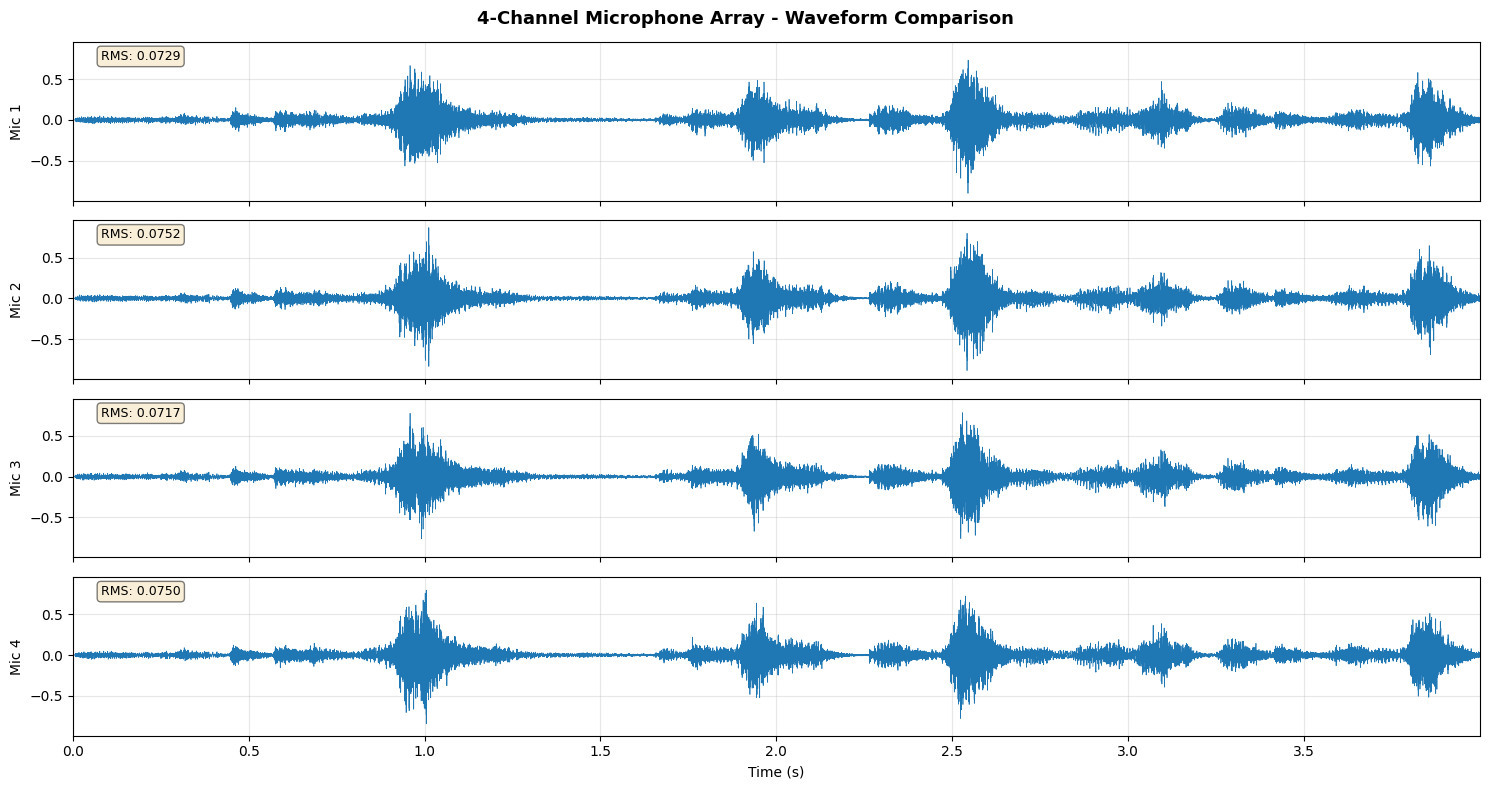


✓ All visualizations complete!
✓ Files saved: dataset_check_sample_13.png, multichannel_comparison_13.png


In [ ]:
# Compare all 4 microphone channels side-by-side
print("\n--- Multi-Channel Comparison ---")
fig, axes = plt.subplots(4, 1, figsize=(15, 8), sharex=True, sharey=True)
time_axis = np.arange(mixed_audio.shape[1]) / 16000

for ch in range(4):
    axes[ch].plot(time_axis, mixed_audio[ch].numpy(), linewidth=0.5)
    axes[ch].set_ylabel(f'Mic {ch+1}')
    axes[ch].grid(True, alpha=0.3)
    axes[ch].set_xlim([0, time_axis[-1]])
    
    # Calculate RMS energy
    rms = np.sqrt(np.mean(mixed_audio[ch].numpy()**2))
    axes[ch].text(0.02, 0.95, f'RMS: {rms:.4f}', transform=axes[ch].transAxes, 
                  fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

axes[-1].set_xlabel('Time (s)')
fig.suptitle('4-Channel Microphone Array - Waveform Comparison', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.savefig(f"multichannel_comparison_{random_idx}.png", dpi=120, bbox_inches='tight')
plt.show()

print(f"\n✓ All visualizations complete!")
print(f"✓ Files saved: dataset_check_sample_{random_idx}.png, multichannel_comparison_{random_idx}.png")